In [1]:
from collections import defaultdict
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from scipy.ndimage import gaussian_filter
import seaborn as sns
from skimage.color import rgb2gray, rgba2rgb
from skimage.io import imread
from skimage.transform import resize
from sklearn.decomposition import PCA
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import sys

current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)
sys.path.insert(0, project_root)

from common.helper import get_split_indices

## Data Directories

In [13]:
img_dir = "../../../../code/imgs/20251211/imgs/in_between_ds/"
random_dir = "../../../../code/imgs/20251211/random/imgs/kspace/complete/"
out_dir = '../../../../code/cosine_sim/20251221/imgs/kspace/complete/'

## Helper Functions 

In [3]:
def parse_U(fname):
    m = re.search(r"U(\d+)", fname)
    return float(m.group(1)) if m else None

In [4]:
def load_gray_image(path, size=256):
    img = imread(path)
    img = resize(img, (size, size))
    # Handle RGBA -> RGB -> grayscale
    if img.ndim == 3:
        if img.shape[2] == 4:
            img = rgba2rgb(img)  # drop alpha safely
        img = rgb2gray(img)
    elif img.ndim == 2:
        img = img  # already grayscale
    else:
        raise ValueError(f"Unexpected image shape: {img.shape}")
    return img

In [5]:
def parse_U_random(name):
    m = re.search(r"U(\d+.\d+)-", name)
    return float(m.group(1)) if m else None

In [6]:
def read_data(dir_path, size=256, sigma_hp=4, random=False):
    imgs = []
    Us = []
    for f in sorted(glob.glob(os.path.join(dir_path, "*.png"))):
        if random:
            U = parse_U_random(f)
        else:
            U = parse_U(f)
        if U is None:
            continue
        img = load_gray_image(f)
        img = (img - img.mean()) / img.std()
        img_hp = img - gaussian_filter(img, sigma=sigma_hp)
        imgs.append(img_hp)
        Us.append(U)
    return np.array(imgs), np.array(Us)

In [7]:
def train_test_split(dataset, labels, val_split=0.0, test_split=0.2, seed=42):
    train_indices, val_indices, test_indices = get_split_indices(dataset.shape[0],
                                                                val_fraction=val_split,
                                                                test_fraction=test_split,
                                                                seed=seed)

    X_train = dataset[train_indices]
    y_train = labels[train_indices]
    if val_indices != []:
        X_valid = dataset[val_indices]
        y_valid = labels[val_indices]
    else:
        X_valid, y_valid = [], []
    X_test = dataset[test_indices]
    y_test = labels[test_indices]
    return X_train, y_train, X_valid, y_valid, X_test, y_test

## Cosine Similarity

In [14]:
imgs, labels = read_data(img_dir)
random_imgs, random_labels = read_data(random_dir, random=True)

In [15]:
# === Load and group ===
groups = defaultdict(list)
for f in sorted(glob.glob(os.path.join(img_dir, "*.png"))):
    U = parse_U(f)
    if U is None:
        continue
    img = load_gray_image(f)
    img = (img - img.mean()) / img.std()
    groups[U].append(img)

In [16]:
# Load other images with different U values
for f in sorted(glob.glob(os.path.join(random_dir, "*.png"))):
    U = parse_U_random(f)
    if U is None:
        continue
    img = load_gray_image(f)
    img = (img - img.mean()) / img.std()
    groups[U].append(img)

In [17]:
# --- Average per U ---
U_vals = sorted(groups.keys())
mean_imgs = np.array([np.mean(groups[U], axis=0) for U in U_vals])

In [18]:
# without subtracting first image
S_act = cosine_similarity(mean_imgs.reshape(mean_imgs.shape[0], -1))

In [19]:
mean_imgs.shape, len(U_vals), S_act.shape

((66, 256, 256), 66, (66, 66))

In [20]:
save_path = os.path.join(out_dir, "similarity_plot.pdf")

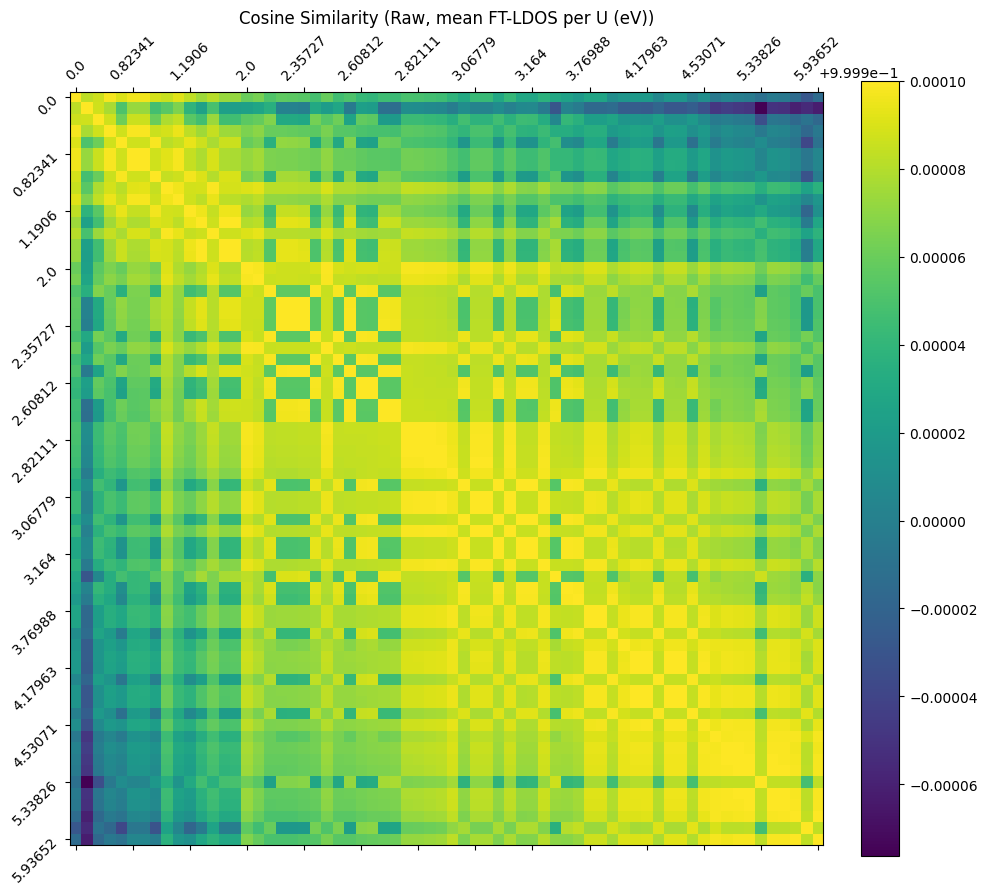

In [21]:
plt.figure(figsize=(12, 10))
cax = plt.matshow(S_act, cmap='viridis', fignum=1)
plt.xticks(range(len(U_vals)), U_vals, rotation=45)
plt.yticks(range(len(U_vals)), U_vals, rotation=45)
plt.locator_params(axis='both', nbins=15)
plt.colorbar(cax, pad=0.04)
plt.title("Cosine Similarity (Raw, mean FT-LDOS per U (eV))")
# plt.tight_layout()
plt.savefig(save_path, dpi=300)
plt.show()

# PCA

In [22]:
# === PCA on averaged FT-LDOS ===
# Stack mean images for PCA
X = np.array([im.flatten() for im in mean_imgs])
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X)

In [23]:
# Reconstruct first 3 eigenimages
components = pca.components_.reshape(-1, mean_imgs.shape[1], mean_imgs.shape[2])

In [24]:
# === Variance maps per U ===
var_maps = {U: np.var(np.stack(groups[U]), axis=0) for U in U_vals}
var_mean = np.mean(list(var_maps.values()), axis=0)

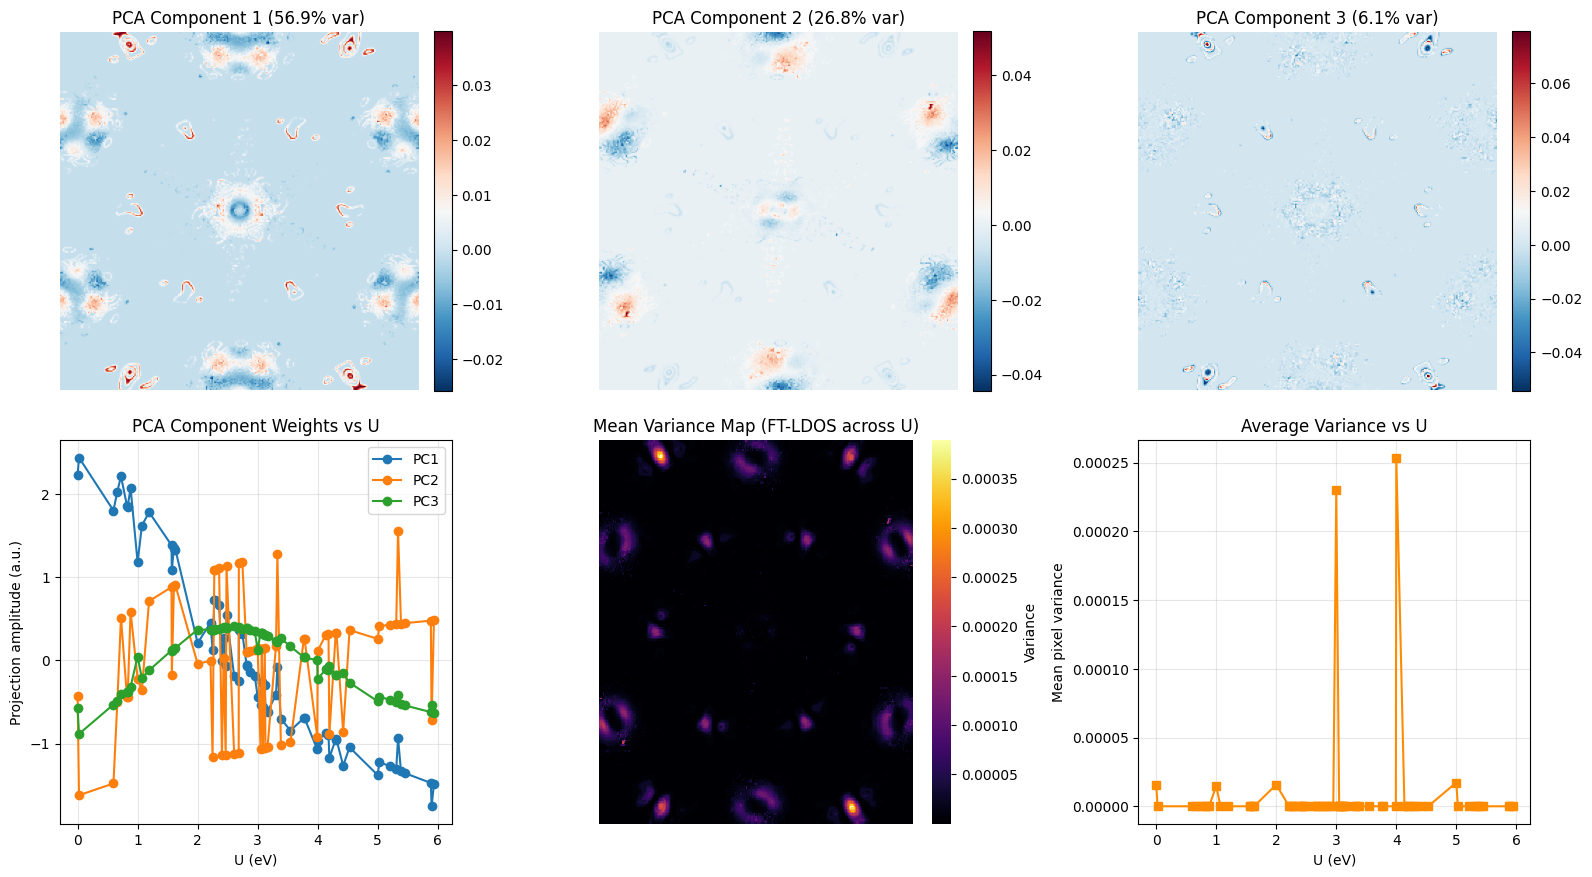

PCA + Variance summary saved → FT_LDOS_PCA_Variance_summary.png


In [25]:
# === Plot everything ===
fig, axs = plt.subplots(2, 3, figsize=(16, 9))
plt.subplots_adjust(hspace=0.4)

# --- PCA eigenimages ---
for i in range(3):
    im = axs[0, i].imshow(components[i], cmap='RdBu_r')
    axs[0, i].set_title(f"PCA Component {i+1} ({pca.explained_variance_ratio_[i]*100:.1f}% var)")
    axs[0, i].axis('off')
    fig.colorbar(im, ax=axs[0, i], orientation='vertical', fraction=0.046, pad=0.04) 

# --- PCA weights vs U ---
for i in range(3):
    axs[1, 0].plot(U_vals, X_pca[:, i], '-o', label=f"PC{i+1}")
axs[1, 0].set_title("PCA Component Weights vs U")
axs[1, 0].set_xlabel("U (eV)")
axs[1, 0].set_ylabel("Projection amplitude (a.u.)")
axs[1, 0].legend()
axs[1, 0].grid(True, alpha=0.3)

# --- Variance map (mean across U) ---
sns.heatmap(var_mean, ax=axs[1, 1], cmap='inferno', cbar_kws={"label": "Variance"})
axs[1, 1].set_title("Mean Variance Map (FT-LDOS across U)")
axs[1, 1].axis('off')

# --- Variance decay vs U ---
var_values = [np.mean(var_maps[U]) for U in U_vals]
axs[1, 2].plot(U_vals, var_values, '-s', color='darkorange')
axs[1, 2].set_title("Average Variance vs U")
axs[1, 2].set_xlabel("U (eV)")
axs[1, 2].set_ylabel("Mean pixel variance")
axs[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(out_dir, "FT_LDOS_PCA_Variance_summary.png"), dpi=300)
plt.show()

print("PCA + Variance summary saved → FT_LDOS_PCA_Variance_summary.png")

# Test small regression on PCA

In [26]:
n_U, H, W = mean_imgs.shape

In [27]:
n_U, H, W

(66, 256, 256)

In [28]:
X = mean_imgs.reshape(n_U, -1)

In [29]:
X.shape

(66, 65536)

In [30]:
scaler1 = StandardScaler()
X_norm = scaler1.fit_transform(X)

In [31]:
X_norm.shape

(66, 65536)

In [32]:
# fit PCA
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_norm)
print("Explained variance ratio:", pca.explained_variance_ratio_)

Explained variance ratio: [0.8555369  0.05679887 0.02742378]


In [33]:
components = pca.components_.reshape(-1, mean_imgs.shape[1], mean_imgs.shape[2])

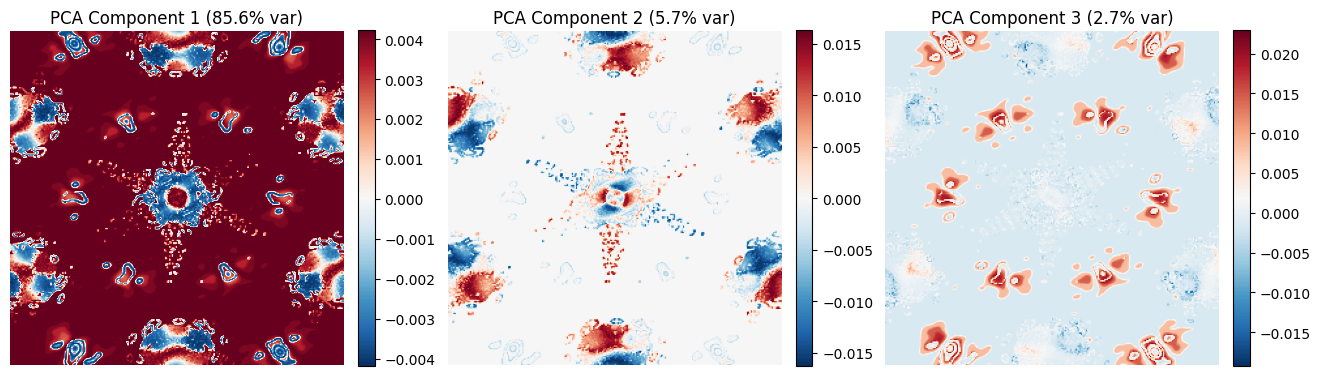

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(16, 9))
plt.subplots_adjust(hspace=0.4)

# --- PCA eigenimages ---
for i in range(3):
    im = axs[i].imshow(components[i], cmap='RdBu_r')
    axs[i].set_title(f"PCA Component {i+1} ({pca.explained_variance_ratio_[i]*100:.1f}% var)")
    axs[i].axis('off')
    fig.colorbar(im, ax=axs[i], orientation='vertical', fraction=0.046, pad=0.04) 

In [35]:
U_values = list(sorted(groups.keys()))

In [36]:
model = Ridge(random_state=42)
model.fit(X_pca, U_values)
pred = model.predict(X_pca)

In [37]:
print("R² =", r2_score(U_values, pred))

R² = 0.9353761507569242


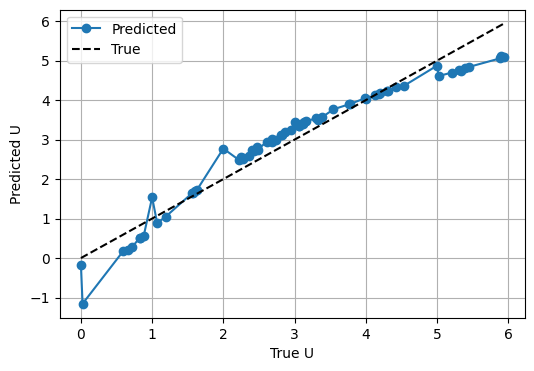

In [38]:
plt.figure(figsize=(6,4))
plt.plot(U_values, pred, 'o-', label='Predicted')
plt.plot(U_values, U_values, 'k--', label='True')
plt.xlabel("True U")
plt.ylabel("Predicted U")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(out_dir, 'pca_true_v_preds.png'), dpi=300)
plt.show()

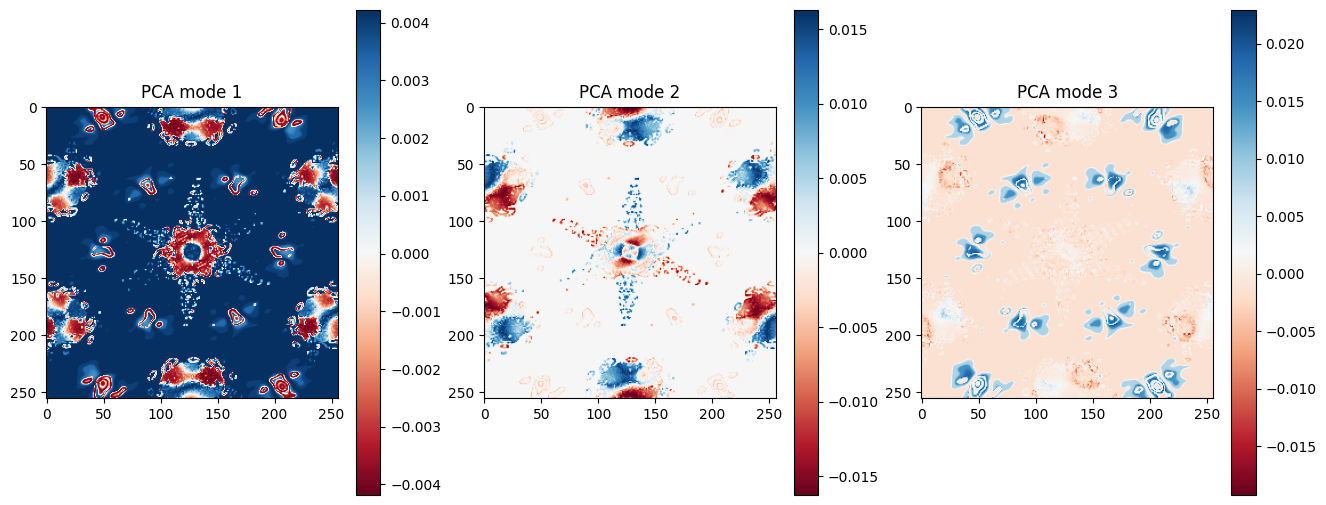

In [39]:
# === Plot everything ===
fig, axs = plt.subplots(1, 3, figsize=(16, 9))
plt.subplots_adjust(hspace=0.4)
ims = []
for i, comp in enumerate(pca.components_[:3]):
    ims.append(axs[i].imshow(comp.reshape(H, W), cmap='RdBu'))
    axs[i].set_title(f'PCA mode {i+1}')
    # axs[i].colorbar()

for i, im in enumerate(ims):
    fig.colorbar(im, ax=axs[i], shrink=0.7)
plt.savefig(os.path.join(out_dir, 'component.png'), dpi=300)
plt.show()

# Full Dataset

In [40]:
imgs, labels = read_data(img_dir, random=True)

In [41]:
X_train, y_train, X_valid, y_valid, X_test, y_test = train_test_split(imgs, labels, test_split=0.2, seed=101)

In [42]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [43]:
sc = StandardScaler()

In [44]:
sc.fit(X_train)
X_train_sc = sc.transform(X_train)
X_test_sc = sc.transform(X_test)

In [45]:
N_COMPONENTS = 3

In [46]:
pca = PCA(n_components=N_COMPONENTS, random_state=101)

In [47]:
pca.fit(X_train_sc)
X_train_pca = pca.transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)

In [48]:
ridge = Ridge(alpha=1.0, random_state=101)
kr = KernelRidge(alpha=1e-3, kernel='rbf', gamma=1e-3)

In [49]:
ridge.fit(X_train_pca, y_train)

,"alpha alpha: {float, ndarray of shape (n_targets,)}, default=1.0Constant that multiplies the L2 term, controlling regularizationstrength. `alpha` must be a non-negative float i.e. in `[0, inf)`.When `alpha = 0`, the objective is equivalent to ordinary leastsquares, solved by the :class:`LinearRegression` object. For numericalreasons, using `alpha = 0` with the `Ridge` object is not advised.Instead, you should use the :class:`LinearRegression` object.If an array is passed, penalties are assumed to be specific to thetargets. Hence they must correspond in number.",1.0
,"fit_intercept fit_intercept: bool, default=TrueWhether to fit the intercept for this model. If setto false, no intercept will be used in calculations(i.e. ``X`` and ``y`` are expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"max_iter max_iter: int, default=NoneMaximum number of iterations for conjugate gradient solver.For 'sparse_cg' and 'lsqr' solvers, the default value is determinedby scipy.sparse.linalg. For 'sag' solver, the default value is 1000.For 'lbfgs' solver, the default value is 15000.",None
,"tol tol: float, default=1e-4The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for each solver:- 'svd': `tol` has no impact.- 'cholesky': `tol` has no impact.- 'sparse_cg': norm of residuals smaller than `tol`.- 'lsqr': `tol` is set as atol and btol of scipy.sparse.linalg.lsqr, which control the norm of the residual vector in terms of the norms of matrix and coefficients.- 'sag' and 'saga': relative change of coef smaller than `tol`.- 'lbfgs': maximum of the absolute (projected) gradient=max|residuals| smaller than `tol`... versionchanged:: 1.2 Default value changed from 1e-3 to 1e-4 for consistency with other linear models.",0.0001
,"solver solver: {'auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'}, default='auto'Solver to use in the computational routines:- 'auto' chooses the solver automatically based on the type of data.- 'svd' uses a Singular Value Decomposition of X to compute the Ridge coefficients. It is the most stable solver, in particular more stable for singular matrices than 'cholesky' at the cost of being slower.- 'cholesky' uses the standard :func:`scipy.linalg.solve` function to obtain a closed-form solution.- 'sparse_cg' uses the conjugate gradient solver as found in :func:`scipy.sparse.linalg.cg`. As an iterative algorithm, this solver is more appropriate than 'cholesky' for large-scale data (possibility to set `tol` and `max_iter`).- 'lsqr' uses the dedicated regularized least-squares routine :func:`scipy.sparse.linalg.lsqr`. It is the fastest and uses an iterative procedure.- 'sag' uses a Stochastic Average Gradient descent, and 'saga' uses its improved, unbiased version named SAGA. Both methods also use an iterative procedure, and are often faster than other solvers when both n_samples and n_features are large. Note that 'sag' and 'saga' fast convergence is only guaranteed on features with approximately the same scale. You can preprocess the data with a scaler from :mod:`sklearn.preprocessing`.- 'lbfgs' uses L-BFGS-B algorithm implemented in :func:`scipy.optimize.minimize`. It can be used only when `positive` is True.All solvers except 'svd' support both dense and sparse data. However, only'lsqr', 'sag', 'sparse_cg', and 'lbfgs' support sparse input when`fit_intercept` is True... versionadded:: 0.17 Stochastic Average Gradient descent solver... versionadded:: 0.19 SAGA solver.",'auto'
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive.Only 'lbfgs' solver is supported in this case.",False
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag' or 'saga' to shuffle the data.See :term:`Glossary ` for details... versionadded:: 0.17 `random_state` to support Stochastic Average Gradient.",101


In [50]:
kr.fit(X_train_pca, y_train)

,"alpha alpha: float or array-like of shape (n_targets,), default=1.0Regularization strength; must be a positive float. Regularizationimproves the conditioning of the problem and reduces the variance ofthe estimates. Larger values specify stronger regularization.Alpha corresponds to ``1 / (2C)`` in other linear models such as:class:`~sklearn.linear_model.LogisticRegression` or:class:`~sklearn.svm.LinearSVC`. If an array is passed, penalties areassumed to be specific to the targets. Hence they must correspond innumber. See :ref:`ridge_regression` for formula.",0.001
,"kernel kernel: str or callable, default=""linear""Kernel mapping used internally. This parameter is directly passed to:class:`~sklearn.metrics.pairwise.pairwise_kernels`.If `kernel` is a string, it must be one of the metricsin `pairwise.PAIRWISE_KERNEL_FUNCTIONS` or ""precomputed"".If `kernel` is ""precomputed"", X is assumed to be a kernel matrix.Alternatively, if `kernel` is a callable function, it is called oneach pair of instances (rows) and the resulting value recorded. Thecallable should take two rows from X as input and return thecorresponding kernel value as a single number. This means thatcallables from :mod:`sklearn.metrics.pairwise` are not allowed, asthey operate on matrices, not single samples. Use the stringidentifying the kernel instead.",'rbf'
,"gamma gamma: float, default=NoneGamma parameter for the RBF, laplacian, polynomial, exponential chi2and sigmoid kernels. Interpretation of the default value is left tothe kernel; see the documentation for sklearn.metrics.pairwise.Ignored by other kernels.",0.001
,"degree degree: float, default=3Degree of the polynomial kernel. Ignored by other kernels.",3
,"coef0 coef0: float, default=1Zero coefficient for polynomial and sigmoid kernels.Ignored by other kernels.",1
,"kernel_params kernel_params: dict, default=NoneAdditional parameters (keyword arguments) for kernel function passedas callable object.",None


In [51]:
pred_ridge = ridge.predict(X_test_pca)
pred_kr = kr.predict(X_test_pca)

In [52]:
for name, pred in zip(["Ridge", "KernelRidge"], [pred_ridge, pred_kr]):
    mae = mean_absolute_error(y_test, pred)
    r2  = r2_score(y_test, pred)
    print(f"{name:12s} | R²={r2:.3f} | MAE={mae:.3f} | mean_pred={pred.mean():.3f}")

Ridge        | R²=0.907 | MAE=0.434 | mean_pred=2.365
KernelRidge  | R²=0.934 | MAE=0.170 | mean_pred=2.341


In [53]:
np_rand_imgs = np.array(random_imgs)
np_rand_imgs = np_rand_imgs.reshape(np_rand_imgs.shape[0], -1)
np_rand_Us = np.array(random_labels)

In [54]:
rand_imgs_sc = sc.transform(np_rand_imgs)
rand_imgs_pca = pca.transform(rand_imgs_sc)

In [55]:
pred_ridge_rand = ridge.predict(rand_imgs_pca)
pred_kr_rand = kr.predict(rand_imgs_pca)

In [56]:
for name, pred in zip(["Ridge", "KernelRidge"], [pred_ridge_rand, pred_kr_rand]):
    mae = mean_absolute_error(np_rand_Us, pred)
    r2  = r2_score(np_rand_Us, pred)
    print(f"{name:12s} | R²={r2:.3f} | MAE={mae:.3f} | mean_pred={pred.mean():.3f}")

Ridge        | R²=0.865 | MAE=0.381 | mean_pred=2.669
KernelRidge  | R²=0.884 | MAE=0.432 | mean_pred=2.616


In [57]:
for act, ridge_pred, kr_pred in zip(random_labels, pred_ridge_rand, pred_kr_rand):
    print(f"Actual: {act}, Ridge Prediction: {ridge_pred}, Kernel Ridge Prediction: {kr_pred}")

Actual: 0.02335, Ridge Prediction: -1.1582916123144367, Kernel Ridge Prediction: 0.00047661138825239036
Actual: 0.59711, Ridge Prediction: -0.08119395814312425, Kernel Ridge Prediction: 0.0040034506327621955
Actual: 0.66178, Ridge Prediction: -0.07005899223452783, Kernel Ridge Prediction: -0.010567173896710358
Actual: 0.72272, Ridge Prediction: 0.10747805636657848, Kernel Ridge Prediction: 0.29257235589813035
Actual: 0.82341, Ridge Prediction: 0.21287364214969617, Kernel Ridge Prediction: -0.03722190651568269
Actual: 0.83316, Ridge Prediction: 0.22708048676607184, Kernel Ridge Prediction: -0.0316952859200228
Actual: 0.88271, Ridge Prediction: 0.3552257231428273, Kernel Ridge Prediction: -0.12124778138604597
Actual: 1.07074, Ridge Prediction: 0.5851846768528766, Kernel Ridge Prediction: 0.8530344568244743
Actual: 1.1906, Ridge Prediction: 0.7614112353821412, Kernel Ridge Prediction: 1.193018797832167
Actual: 1.56432, Ridge Prediction: 1.291745482086558, Kernel Ridge Prediction: 1.139184